# Deep research Multiagent system


### Original doc:

    https://www.youtube.com/watch?v=mjPSkPLbu1s

<div style="width: 100%; height: 768px; overflow: hidden;">
  <iframe width="1024" height="768" src="https://www.youtube.com/embed/mjPSkPLbu1s?si=nrN8Y4pnHNAj-5WZ" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" referrerpolicy="strict-origin-when-cross-origin" allowfullscreen></iframe>
</div>

In [9]:
%%capture --no-stderr
%pip install -U --upgrade pip langgraph langchain_community langchain_anthropic langchain-tavily langchain_experimental langchain_ollama mcp langchain-mcp-adapters

In [ ]:
from langfuse.callback import CallbackHandler
# load environment variables from .env file
from dotenv import load_dotenv
load_dotenv()
# Initialize Langfuse CallbackHandler for LangGraph/Langchain (tracing)
langfuse_handler = CallbackHandler() 
 

In [ ]:
from langchain_core.tools import tool 
from langchain_ollama import ChatOllama
from langgraph.prebuilt import create_react_agent
from tools.file_operations import read_file

def create_agent(name, model, tools):
  # load text from file 
  system_prompt = read_file.invoke(f'prompts/{name}_system.md')
  # print('system_prompt',system_prompt)
  # Create the agent
  return create_react_agent(name=name, model=ChatOllama(model=model), 
    tools=tools, response_format='json', prompt=system_prompt)



In [3]:
planner_agent = create_agent("planner_agent", "qwen3", [])

input_message = {"role": "user", "content": "How to build a Multi-Agent Deep Research System"}

# Use the agent
config = {"configurable": {"thread_id": "abc123"}, "recursion_limit": 10, "callbacks": [langfuse_handler]}
for step in planner_agent.stream(
    {"messages": [input_message]}, config, stream_mode="values"
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

How to build a Multi-Agent Deep Research System
================================== Ai Message ==================================
Name: planner_agent

<think>
Okay, the user is asking about building a Multi-Agent Deep Research System. Let me break this down. First, I need to understand what exactly they mean by a Multi-Agent system in the context of deep research. Multi-Agent systems usually involve multiple autonomous agents interacting, so maybe they're looking into AI systems where multiple agents collaborate or compete.

The term "Deep Research System" is a bit unclear. It could refer to using deep learning techniques within the multi-agent framework, or it might be a system designed for deep research tasks. I should consider both possibilities. 

The user might be interested in the architecture of such a system. So, one question could be about the key components or architecture needed. Another aspect 

In [ ]:
from langchain_tavily import TavilySearch
import json

search_agent = create_agent("search_agent", "qwen3", [TavilySearch(max_results=1)])
content = read_file.invoke('prompts/planner_agent_output_example.json')
# Convert string to json object
content = json.loads(content)
 
for question in content['questions']:
    input_message = {"role": "user", "content": json.dumps(question) + " /no_think",}

    # Use the agent
    config = {"configurable": {"thread_id": "abc123"}, "recursion_limit": 10, "callbacks": [langfuse_handler]}
    for step in search_agent.stream(
        {"messages": [input_message]}, config, stream_mode="values"
    ):
        step["messages"][-1].pretty_print()

# function that adds two numbers
def add(a, b):
    return a + b

# declacion de una lista de strings
strings = ["Hello", "world", "!"]

{'topic': 'How to build a Multi-Agent Deep Research System', 'questions': [{'question': 'What are the key architectural frameworks and design patterns for developing multi-agent systems that integrate deep learning techniques?'}, {'question': 'What technical components (e.g., agent communication protocols, reward mechanisms, or neural network architectures) are essential for implementing a multi-agent deep research system?'}, {'question': 'What challenges arise when combining multi-agent systems with deep learning, and how can they be mitigated?'}]}
================================ Human Message =================================

{"question": "What are the key architectural frameworks and design patterns for developing multi-agent systems that integrate deep learning techniques?"} /no_think
================================== Ai Message ==================================
Name: search_agent

<think>

</think>
Tool Calls:
  tavily_search (84631422-27e8-467f-9b86-811b4ec1e45c)
 Call ID: 84

In [3]:
from tools.web_operations import scrape_webpages
import json

summarization_agent = create_agent("summarization_agent", "qwen3:14b", [scrape_webpages])
content = read_file.invoke('prompts/search_agent_output_example.json')
# Convert string to json object
content = json.loads(content)

for question in content['questions']:
    input_message = {"role": "user", "content": json.dumps(question),}

    # Use the agent
    config = {"configurable": {"thread_id": "abc123"}, "recursion_limit": 10, "callbacks": [langfuse_handler]}
    for step in summarization_agent.stream(
        {"messages": [input_message]}, config, stream_mode="values"
    ):
        step["messages"][-1].pretty_print()

================================ Human Message =================================

{"question": "What are the key architectural frameworks and design patterns for developing multi-agent systems that integrate deep learning techniques?", "results": [{"url": "https://medium.com/@aydinKerem/ai-agents-design-patterns-explained-b3ac0433c915", "title": "AI Agents Design Patterns Explained | by Kerem Ayd\u0131n - Medium", "content": "In this article, we explored the evolving landscape of AI agents and their design patterns, highlighting how agentic frameworks have democratized the development of complex AI systems. By discussing foundational concepts and practical implementations like the ReAct pattern, we demonstrated that simpler, cost-effective architectures can often solve specific tasks efficiently. We also examined advanced multi-agent systems, planning agents, and reflection frameworks that enhance AI capabilities.", "summary": "The article discusses AI agents' design patterns, includin

<div class="admonition tip">
    <p class="admonition-title">Set up <a href="https://smith.langchain.com">LangSmith</a> for LangGraph development</p>
    <p style="padding-top: 5px;">
        Sign up for LangSmith to quickly spot issues and improve the performance of your LangGraph projects. LangSmith lets you use trace data to debug, test, and monitor your LLM apps built with LangGraph — read more about how to get started <a href="https://docs.smith.langchain.com">here</a>. 
    </p>
</div>

## Create Tools

Each team will be composed of one or more agents each with one or more tools. Below, define all the tools to be used by your different teams.

We'll start with the research team.

**ResearchTeam tools**

The research team can use a search engine and url scraper to find information on the web. Feel free to add additional functionality below to boost the team performance!

In [ ]:

from web_scraper import scrape_webpages


**Document writing team tools**

Next up, we will give some tools for the doc writing team to use.
We define some bare-bones file-access tools below.

Note that this gives the agents access to your file-system, which can be unsafe. We also haven't optimized the tool descriptions for performance.

## Helper Utilities

We are going to create a few utility functions to make it more concise when we want to:

1. Create a worker agent.
2. Create a supervisor for the sub-graph.

These will simplify the graph compositional code at the end for us so it's easier to see what's going on.

In [13]:
from typing import List, Optional, Literal
from langchain_core.language_models.chat_models import BaseChatModel

from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.types import Command
from langchain_core.messages import HumanMessage, trim_messages


class State(MessagesState):
    next: str


def make_supervisor_node(llm: BaseChatModel, members: list[str]) -> str:
    options = ["FINISH"] + members
    system_prompt = (
        "You are a supervisor tasked with managing a conversation between the"
        f" following workers: {members}. Given the following user request,"
        " respond with the worker to act next. Each worker will perform a"
        " task and respond with their results and status. When finished,"
        " respond with FINISH."
    )

    class Router(TypedDict):
        """Worker to route to next. If no workers needed, route to FINISH."""

        next: Literal[*options]

    def supervisor_node(state: State) -> Command[Literal[*members, "__end__"]]:
        """An LLM-based router."""
        messages = [
            {"role": "system", "content": system_prompt},
        ] + state["messages"]
        response = llm.with_structured_output(Router).invoke(messages)
        goto = response["next"]
        if goto == "FINISH":
            goto = END

        return Command(goto=goto, update={"next": goto})

    return supervisor_node

## Define Agent Teams

Now we can get to define our hierarchical teams. "Choose your player!"

### Research Team

The research team will have a search agent and a web scraping "research_agent" as the two worker nodes. Let's create those, as well as the team supervisor.

In [14]:
from langchain_core.messages import HumanMessage
from langchain_ollama import ChatOllama
from langgraph.prebuilt import create_react_agent

llm = ChatOllama(model="qwen3")

search_agent = create_react_agent(llm, tools=[tavily_tool])


def search_node(state: State) -> Command[Literal["supervisor"]]:
    result = search_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="search")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )


web_scraper_agent = create_react_agent(llm, tools=[scrape_webpages])


def web_scraper_node(state: State) -> Command[Literal["supervisor"]]:
    result = web_scraper_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="web_scraper")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )


research_supervisor_node = make_supervisor_node(llm, ["search", "web_scraper"])

Now that we've created the necessary components, defining their interactions is easy. Add the nodes to the team graph, and define the edges, which determine the transition criteria.

In [15]:
research_builder = StateGraph(State)
research_builder.add_node("supervisor", research_supervisor_node)
research_builder.add_node("search", search_node)
research_builder.add_node("web_scraper", web_scraper_node)

research_builder.add_edge(START, "supervisor")
research_graph = research_builder.compile()

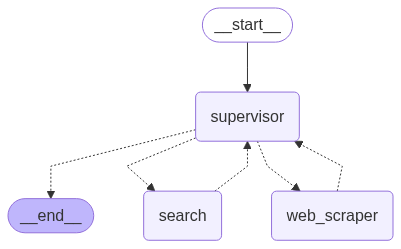

In [16]:
from IPython.display import Image, display

display(Image(research_graph.get_graph().draw_mermaid_png()))

We can give this team work directly. Try it out below.

In [17]:
# for s in research_graph.stream(
#     {"messages": [("user", "when is Ed Sheeran's next tour in 2025?")]},
#     config={"recursion_limit": 100, "callbacks": [langfuse_handler]},
#     ):
#     print(s)
#     print("---")

### Document Writing Team

Create the document writing team below using a similar approach. This time, we will give each agent access to different file-writing tools.

Note that we are giving file-system access to our agent here, which is not safe in all cases.

In [18]:
llm = ChatOllama(model="qwen3")

doc_writer_agent = create_react_agent(
    llm,
    tools=[write_document, edit_document, read_document],
    prompt=(
        "You can read, write and edit documents based on note-taker's outlines. "
        "Don't ask follow-up questions."
    ),
)


def doc_writing_node(state: State) -> Command[Literal["supervisor"]]:
    result = doc_writer_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="doc_writer")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )


note_taking_agent = create_react_agent(
    llm,
    tools=[create_outline, read_document],
    prompt=(
        "You can read documents and create outlines for the document writer. "
        "Don't ask follow-up questions."
    ),
)


def note_taking_node(state: State) -> Command[Literal["supervisor"]]:
    result = note_taking_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="note_taker")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )


chart_generating_agent = create_react_agent(
    llm, tools=[read_document, python_repl_tool]
)


def chart_generating_node(state: State) -> Command[Literal["supervisor"]]:
    result = chart_generating_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=result["messages"][-1].content, name="chart_generator"
                )
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )


doc_writing_supervisor_node = make_supervisor_node(
    llm, ["doc_writer", "note_taker", "chart_generator"]
)

With the objects themselves created, we can form the graph.

In [19]:
# Create the graph here
paper_writing_builder = StateGraph(State)
paper_writing_builder.add_node("supervisor", doc_writing_supervisor_node)
paper_writing_builder.add_node("doc_writer", doc_writing_node)
paper_writing_builder.add_node("note_taker", note_taking_node)
paper_writing_builder.add_node("chart_generator", chart_generating_node)

paper_writing_builder.add_edge(START, "supervisor")
paper_writing_graph = paper_writing_builder.compile()

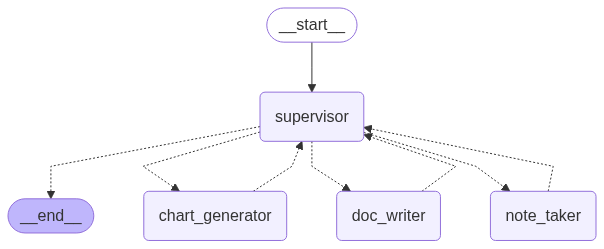

In [20]:
from IPython.display import Image, display

display(Image(paper_writing_graph.get_graph().draw_mermaid_png()))

In [21]:
# for s in paper_writing_graph.stream(
#     {
#         "messages": [
#             (
#                 "user",
#                 "Write an outline for poem about cats and then write the poem to disk.",
#             )
#         ]
#     },
#     {"recursion_limit": 100, "callbacks": [langfuse_handler]},
# ):
#     print(s)
#     print("---")

## Add Layers

In this design, we are enforcing a top-down planning policy. We've created two graphs already, but we have to decide how to route work between the two.

We'll create a _third_ graph to orchestrate the previous two, and add some connectors to define how this top-level state is shared between the different graphs.

In [22]:
from langchain_core.messages import BaseMessage

teams_supervisor_node = make_supervisor_node(llm, ["research_team", "writing_team"])

In [23]:
def call_research_team(state: State) -> Command[Literal["supervisor"]]:
    response = research_graph.invoke({"messages": state["messages"][-1]})
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=response["messages"][-1].content, name="research_team"
                )
            ]
        },
        goto="supervisor",
    )


def call_paper_writing_team(state: State) -> Command[Literal["supervisor"]]:
    response = paper_writing_graph.invoke({"messages": state["messages"][-1]})
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=response["messages"][-1].content, name="writing_team"
                )
            ]
        },
        goto="supervisor",
    )


# Define the graph.
super_builder = StateGraph(State)
super_builder.add_node("supervisor", teams_supervisor_node)
super_builder.add_node("research_team", call_research_team)
super_builder.add_node("writing_team", call_paper_writing_team)

super_builder.add_edge(START, "supervisor")
super_graph = super_builder.compile()

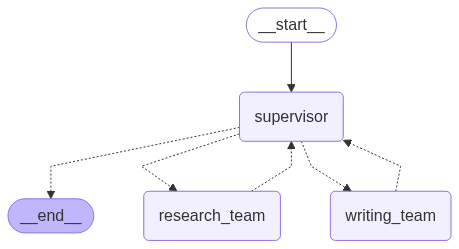

In [24]:
from IPython.display import Image, display

display(Image(super_graph.get_graph().draw_mermaid_png()))

In [25]:
for s in super_graph.stream(
    {
        "messages": [
            ("user", "Research AI agents and write in a file using the writing_team a brief report about them.")
        ],
    },
    {"recursion_limit": 150, "callbacks": [langfuse_handler]},
):
    print(s)
    print("---")

{'supervisor': {'next': 'research_team'}}
---
{'research_team': {'messages': [HumanMessage(content="<think>\nOkay, let me start by understanding the user's request. They want a brief report on AI agents using the writing_team. Since I can't actually use a writing_team, I'll need to generate the report based on the research done via the tavily_search function.\n\nFirst, I'll review the search results to gather key points. The articles mention different types of AI agents, like simple reflex, model-based, goal-based, utility-based, and learning agents. Each has specific applications and strengths. For example, learning agents are useful in dynamic environments like autonomous driving.\n\nThe applications section should highlight areas like customer support, finance, HR, and decision-making. Challenges include ethical concerns, data privacy, and ensuring reliability. Future trends mention advancements in agentic AI and integration with tools for autonomy.\n\nI need to structure the report